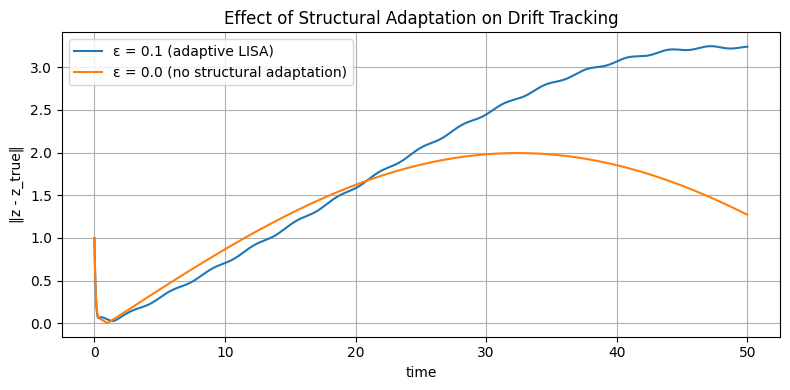

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sys, os
from pathlib import Path

# Add repo root to path
def find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists():
            return candidate
    return start

repo_root = find_repo_root(Path.cwd())
if "__file__" in globals():
    file_root = find_repo_root(Path(__file__).resolve().parent)
    if (file_root / "pyproject.toml").exists():
        repo_root = file_root
sys.path.append(str(repo_root))
from lisa import LISAConfig, LISADynamicalSystem, linear_manifold, LISAState

def run_sim(epsilon: float):
    cfg = LISAConfig(n_states=2, n_params=4, epsilon=epsilon, gamma=5.0)
    sys_lisa = LISADynamicalSystem(cfg, linear_manifold, k_fast=10.0)

    def u(t): return np.array([np.sin(t), np.cos(t)], dtype=float)

    def z_true(u_t, t):
        angle = 0.1 * t
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle),  np.cos(angle)]], dtype=float)
        return R @ u_t

    z0 = np.zeros(2, dtype=float)
    theta0 = np.eye(2, dtype=float).flatten()
    state0 = LISAState(z=z0, theta=theta0).as_vector()

    t_span = np.linspace(0.0, 50.0, 1000)

    def rhs(y, t):
        return sys_lisa.rhs(t, y, u(t))

    traj = odeint(rhs, state0, t_span)
    z_hist = traj[:, :2]

    errors = []
    for i, t in enumerate(t_span):
        errors.append(np.linalg.norm(z_hist[i] - z_true(u(t), t)))

    return t_span, np.asarray(errors)

# Run Comparison
t, err_eps = run_sim(epsilon=0.1)
_, err_no_adapt = run_sim(epsilon=0.0)

# Plot Figure 1
plt.figure(figsize=(8, 4))
plt.plot(t, err_eps, label="ε = 0.1 (adaptive LISA)")
plt.plot(t, err_no_adapt, label="ε = 0.0 (no structural adaptation)")
plt.xlabel("time")
plt.ylabel("‖z - z_true‖")
plt.title("Effect of Structural Adaptation on Drift Tracking")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
